In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, roc_curve, precision_recall_curve
)   

In [2]:
DATA_PATH = Path("creditcard.csv")  
df = pd.read_csv(DATA_PATH)

In [3]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [4]:
# -- 'Time' is seconds from the first transaction; it may capture daily or weekly transaction patterns.
# -- 'V1'-'V28' Anonymized features created with PCA; original meanings are not disclosed but they carry important information.
# -- 'Amount' is raw transaction value and strongly right-skewed; it is informative but must be controlled for scale/outliers.
# -- 'Class' is our label: 0 = normal, 1 = fraud. Very imbalanced, so metrics like recall matter more than accuracy.
before = len(df)
df = df.drop_duplicates()
print(f"[Cleaning] Duplicates removed: {before - len(df)}")

[Cleaning] Duplicates removed: 1081


In [5]:
# -- Split off the labels after cleaning, so y always matches the rows in X
assert "Class" in df.columns, "Expect a target column named 'Class'."
y = df["Class"].astype(int)
X = df.drop(columns=["Class"])

In [6]:
# -- KNN is distance-based. If 'Amount' is huge, it can overshadow the other features.
# -- IQR clipping keeps the overall pattern while taming extreme values.
def iqr_clip(series, k=1.5):
    q1, q3 = np.percentile(series, [25, 75])
    iqr = q3 - q1
    low, high = q1 - k * iqr, q3 + k * iqr
    return np.clip(series, low, high)

if "Amount" in X.columns:
    X["Amount"] = iqr_clip(X["Amount"], k=1.5)

In [7]:
# Train/test split — keep the original class imbalance in TEST to reflect real-world prevalence.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print(f"[Split] Train={len(y_train)}, Test={len(y_test)}, Test fraud rate={y_test.mean():.4%}")

[Split] Train=226980, Test=56746, Test fraud rate=0.1674%


In [8]:
#  - Median is robust for long-tailed numeric features like 'Amount'.
#  - KNN MUST be scaled (StandardScaler) so 'Amount'/'Time' won't dominate distance.
num_cols = X_train.columns.tolist()
num_pre = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
pre = ColumnTransformer([
    ("num", num_pre, num_cols)
], remainder="drop")

In [9]:
# -- Imbalance handling for training only, light undersampling to stabilize KNN runtime and improve minority neighborhood quality.
fraud_idx = y_train[y_train == 1].index
nonfraud_idx = y_train[y_train == 0].index
rng = np.random.default_rng(42)
nonfraud_sample = rng.choice(nonfraud_idx, size=min(len(nonfraud_idx), 3 * len(fraud_idx)), replace=False)
sel_idx = np.concatenate([fraud_idx.values, nonfraud_sample])
X_train_bal = X_train.loc[sel_idx]
y_train_bal = y_train.loc[sel_idx]
print(f"[Balance] TRAIN balanced size={len(y_train_bal)} | fraud={y_train_bal.sum()} | nonfraud={len(y_train_bal)-y_train_bal.sum()}")

[Balance] TRAIN balanced size=1512 | fraud=378 | nonfraud=1134


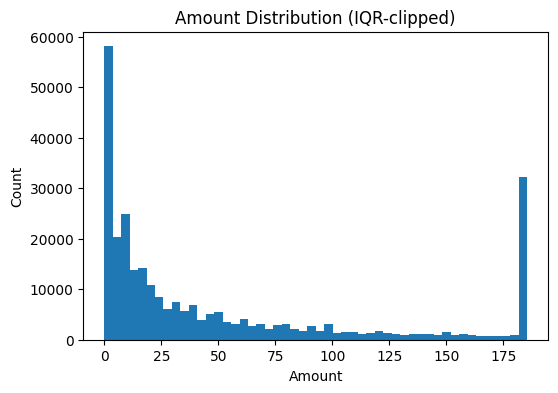

In [10]:
# -- Look at the distribution of 'Amount'. It still shows a right-skew with a long tail.
plt.figure(figsize=(6,4))
plt.hist(X["Amount"], bins=50)
plt.xlabel("Amount"); plt.ylabel("Count"); plt.title("Amount Distribution (IQR-clipped)")
plt.show()

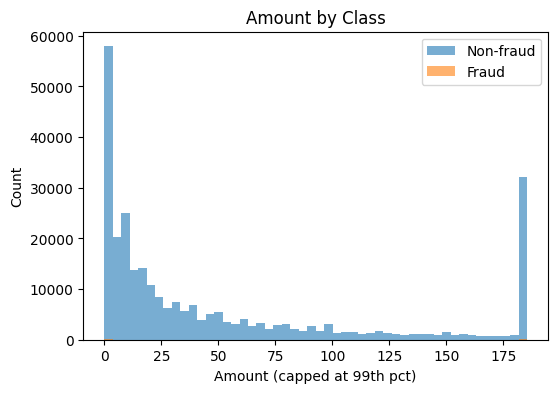

In [11]:
# -- Insight: raw 'Amount' alone is not decisive; its interaction with PCA components matters more.
q = X["Amount"].quantile(0.99)
plt.figure(figsize=(6,4))
plt.hist(X.loc[y==0, "Amount"].clip(upper=q), bins=50, alpha=0.6, label="Non-fraud")
plt.hist(X.loc[y==1, "Amount"].clip(upper=q), bins=50, alpha=0.6, label="Fraud")
plt.xlabel("Amount (capped at 99th pct)"); plt.ylabel("Count"); plt.title("Amount by Class")
plt.legend(); plt.show()

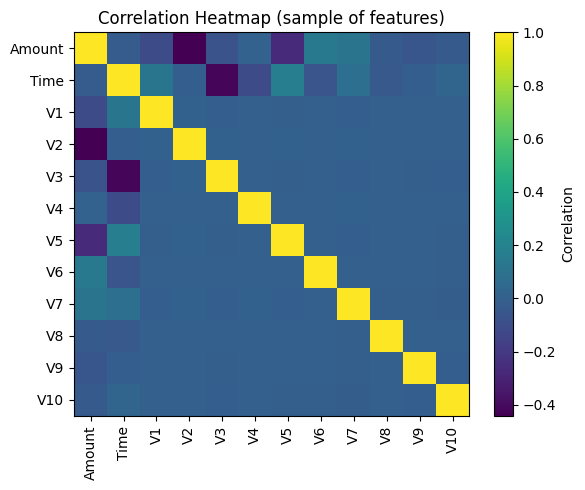

In [12]:
# -- Correlation heatmap among a small subset (to be readable); PCA components are largely uncorrelated by design.
subset_cols = ["Amount", "Time"] + [c for c in X.columns if c.startswith("V")][:10]
corr = pd.DataFrame(X[subset_cols]).corr()
plt.figure(figsize=(6,5))
plt.imshow(corr, cmap="viridis", aspect="auto")
plt.colorbar(label="Correlation")
plt.xticks(range(len(subset_cols)), subset_cols, rotation=90)
plt.yticks(range(len(subset_cols)), subset_cols)
plt.title("Correlation Heatmap (sample of features)")
plt.tight_layout(); plt.show()

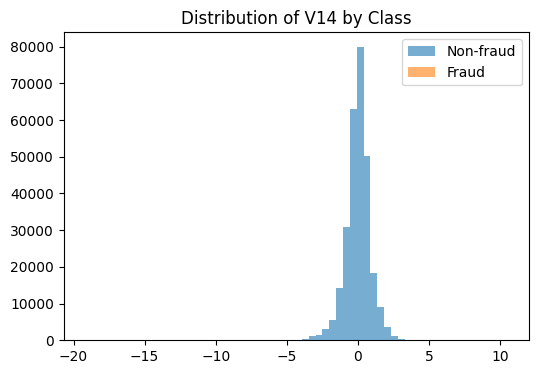

In [13]:
# -- PCA component shift check (example: distribution of V14 vs class) — subtle but informative shifts.
if "V14" in X.columns:
    plt.figure(figsize=(6,4))
    plt.hist(X.loc[y==0, "V14"], bins=60, alpha=0.6, label="Non-fraud")
    plt.hist(X.loc[y==1, "V14"], bins=60, alpha=0.6, label="Fraud")
    plt.title("Distribution of V14 by Class")
    plt.legend(); plt.show()

In [14]:
# -- Modeling — KNN with scaling & optional PCA
use_pca = True
steps = [("pre", pre)]
if use_pca:
    steps.append(("pca", PCA(n_components=0.95, svd_solver="full", random_state=42)))
steps.append(("knn", KNeighborsClassifier()))
pipe = Pipeline(steps)

In [15]:
# -- n_neighbors -> bias-variance tradeoff (small k risks overfitting fraud; large k may miss rare patterns)
# -- weights='distance' lets closer neighbors dominate (intuitive for fraud proximity)
# -- p=2 Euclidean; p=1 Manhattan could be added if needed
param_grid = {
    "knn__n_neighbors": [5, 15, 25],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [2]
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid=param_grid, scoring="roc_auc", cv=cv, n_jobs=-1, verbose=0)

In [16]:
# -- Fit on BALANCED train; evaluate on original TEST (keeps real-world class ratio)
gs.fit(X_train_bal, y_train_bal)
print("[Model] Best params:", gs.best_params_)
best_model = gs.best_estimator_

[Model] Best params: {'knn__n_neighbors': 25, 'knn__p': 2, 'knn__weights': 'distance'}


In [17]:
# -- Evaluation — show metrics & plots directly (no saving)
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_prob)
pr_auc  = average_precision_score(y_test, y_prob)

In [18]:
# -- Metrics table — directly display instead of saving
metrics_df = pd.DataFrame({
    "ROC_AUC":[roc_auc],
    "PR_AUC":[pr_auc],
    "Best_Params":[str(gs.best_params_)],
    "Train_Balanced_Size":[len(y_train_bal)],
    "Test_Size":[len(y_test)]
})
print("\n=== Metrics (original imbalanced TEST) ===")
print(metrics_df, "\n")

print("=== Classification report (threshold=0.5) ===")
print(classification_report(y_test, y_pred, digits=4))
print("=== Confusion matrix (threshold=0.5) ===")
print(confusion_matrix(y_test, y_pred))


=== Metrics (original imbalanced TEST) ===
   ROC_AUC    PR_AUC                                        Best_Params  \
0  0.94589  0.686992  {'knn__n_neighbors': 25, 'knn__p': 2, 'knn__we...   

   Train_Balanced_Size  Test_Size  
0                 1512      56746   

=== Classification report (threshold=0.5) ===
              precision    recall  f1-score   support

           0     0.9996    0.9985    0.9991     56651
           1     0.4650    0.7684    0.5794        95

    accuracy                         0.9981     56746
   macro avg     0.7323    0.8835    0.7892     56746
weighted avg     0.9987    0.9981    0.9984     56746

=== Confusion matrix (threshold=0.5) ===
[[56567    84]
 [   22    73]]


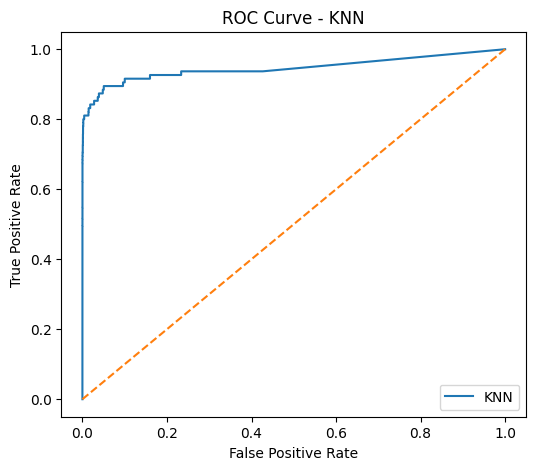

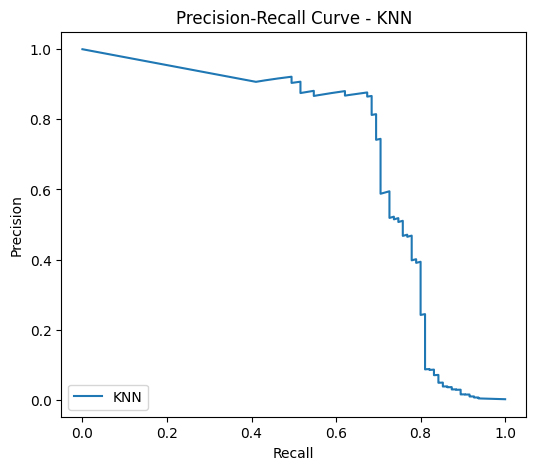

In [19]:
# -- ROC curve — displayed
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="KNN")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve - KNN"); plt.legend(loc="lower right")
plt.show()

# -- PR curve — displayed
prec, rec, thr = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label="KNN")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve - KNN"); plt.legend(loc="lower left")
plt.show()

In [20]:
# -- Threshold tuning — (i) best F1 and (ii) target recall example (e.g., 0.90)
def pick_threshold_for_best_f1(y_true, y_score):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    thr = np.append(thr, 1.0)
    f1 = 2*(prec*rec)/(prec+rec+1e-12)
    i = np.nanargmax(f1)
    return float(thr[i]), float(f1[i]), float(prec[i]), float(rec[i])

best_thr, best_f1, best_p, best_r = pick_threshold_for_best_f1(y_test, y_prob)
print(f"\n[F1-opt] threshold={best_thr:.4f} | F1={best_f1:.4f} | Precision={best_p:.4f} | Recall={best_r:.4f}")

y_pred_f1 = (y_prob >= best_thr).astype(int)
print("\n=== Report @F1-opt threshold ===")
print(classification_report(y_test, y_pred_f1, digits=4))
print("=== Confusion matrix @F1-opt ===")
print(confusion_matrix(y_test, y_pred_f1))

def pick_threshold_for_target_recall(y_true, y_score, target_recall=0.90):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    thr = np.append(thr, 1.0)
    idx = np.where(rec >= target_recall)[0]
    if len(idx) == 0:
        return float(thr[-1]), float(rec[-1]), float(prec[-1])
    i = idx[0]
    return float(thr[i]), float(rec[i]), float(prec[i])

thr_r90, r90, p_at_r90 = pick_threshold_for_target_recall(y_test, y_prob, 0.90)
print(f"\n[Recall>=0.90] threshold={thr_r90:.4f} | Recall={r90:.4f} | Precision={p_at_r90:.4f}")
print("=== Confusion matrix @Recall>=0.90 ===")
print(confusion_matrix(y_test, (y_prob >= thr_r90).astype(int)))


[F1-opt] threshold=0.8163 | F1=0.7647 | Precision=0.8667 | Recall=0.6842

=== Report @F1-opt threshold ===
              precision    recall  f1-score   support

           0     0.9995    0.9998    0.9996     56651
           1     0.8667    0.6842    0.7647        95

    accuracy                         0.9993     56746
   macro avg     0.9331    0.8420    0.8822     56746
weighted avg     0.9992    0.9993    0.9993     56746

=== Confusion matrix @F1-opt ===
[[56641    10]
 [   30    65]]

[Recall>=0.90] threshold=0.0000 | Recall=1.0000 | Precision=0.0017
=== Confusion matrix @Recall>=0.90 ===
[[    0 56651]
 [    0    95]]


# COMP647 — Assignment 3  
**Credit Card Fraud Detection — Extended Analysis**

The following section extends the work from Assignment 2 using the same dataset.

In [36]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    average_precision_score, precision_recall_curve,
    confusion_matrix, classification_report, f1_score,
    roc_auc_score, roc_curve, auc
)

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [22]:
DATA_PATH = Path("creditcard.csv")
df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()

In [23]:
df.shape, df.head()

((284807, 31),
    Time        V1        V2        V3        V4        V5        V6        V7  \
 0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
 1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
 2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
 3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
 4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
 
          V8        V9  ...       V21       V22       V23       V24       V25  \
 0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
 1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
 2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
 3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
 4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   
 
   

In [ ]:
# -- The original dataset includes 'Time' (seconds since first transaction).
# -- To preserve cyclical nature, Time was transformed into Hour and encoded using sine and cosine transformations (sin_hour, cos_hour).
# -- All numeric features were scaled using RobustScaler, which reduces the influence of extreme values
df['Hour'] = (df['Time'] % 86400) / 3600.0
df['sin_hour'] = np.sin(2*np.pi*df['Hour']/24.0)
df['cos_hour'] = np.cos(2*np.pi*df['Hour']/24.0)

# -- Separate target and drop the raw 'Time'
y = df['Class'].astype(int)
X = df.drop(columns=['Class', 'Time'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

# -- RobustScaler for heavy-tailed amounts
num_cols = X_train.columns.tolist()
preprocess = ColumnTransformer(
    transformers=[('scale', RobustScaler(), num_cols)],
    remainder='drop'
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (227845, 32) Test: (56962, 32)


In [ ]:
# -- MI was used to identify non-linear dependencies between features and the target variable.
# -- k was set to 20 after quick sensitivity checks.
k = 20
mi_selector = SelectKBest(score_func=mutual_info_classif, k=k)

pipe_featselect = Pipeline([
    ('prep', preprocess),
    ('mi', mi_selector),
])

pipe_featselect.fit(X_train, y_train)
X_train_sel = pipe_featselect.transform(X_train)
X_test_sel = pipe_featselect.transform(X_test)

print("Selected Features:", X_train_sel.shape)

Selected Features: (227845, 20)


In [ ]:
# -- Top 10 — displayed
scores = mi_selector.scores_
mi_rank = pd.DataFrame({
    'Feature': X_train.columns,
    'MI_Score': scores
}).sort_values('MI_Score', ascending=False)

print(mi_rank.head(10))

   Feature  MI_Score
13     V14  0.008135
16     V17  0.008099
11     V12  0.007534
9      V10  0.007518
10     V11  0.006685
15     V16  0.005930
3       V4  0.005073
2       V3  0.004939
8       V9  0.004318
17     V18  0.004151


In [ ]:
# -- Evaluate model performance.
def evaluate_model(clf, X_tr, y_tr, X_te, y_te, name="model"):
    clf.fit(X_tr, y_tr)
    y_prob = clf.predict_proba(X_te)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    ap = average_precision_score(y_te, y_prob)
    roc = roc_auc_score(y_te, y_prob)
    f1 = f1_score(y_te, y_pred)

    print(f"[{name}] PR-AUC: {ap:.4f} | ROC-AUC: {roc:.4f} | F1@0.5: {f1:.4f}")
    print(classification_report(y_te, y_pred, digits=4))
    return y_prob

In [ ]:
# -- Metrics table for Logistic Regression
logreg = LogisticRegression(class_weight='balanced', max_iter=2000, random_state=RANDOM_STATE)
prob_lr = evaluate_model(logreg, X_train_sel, y_train, X_test_sel, y_test, "Logistic Regression")

[Logistic Regression] PR-AUC: 0.7198 | ROC-AUC: 0.9722 | F1@0.5: 0.1077
              precision    recall  f1-score   support

           0     0.9999    0.9739    0.9867     56864
           1     0.0572    0.9184    0.1077        98

    accuracy                         0.9738     56962
   macro avg     0.5285    0.9461    0.5472     56962
weighted avg     0.9982    0.9738    0.9852     56962



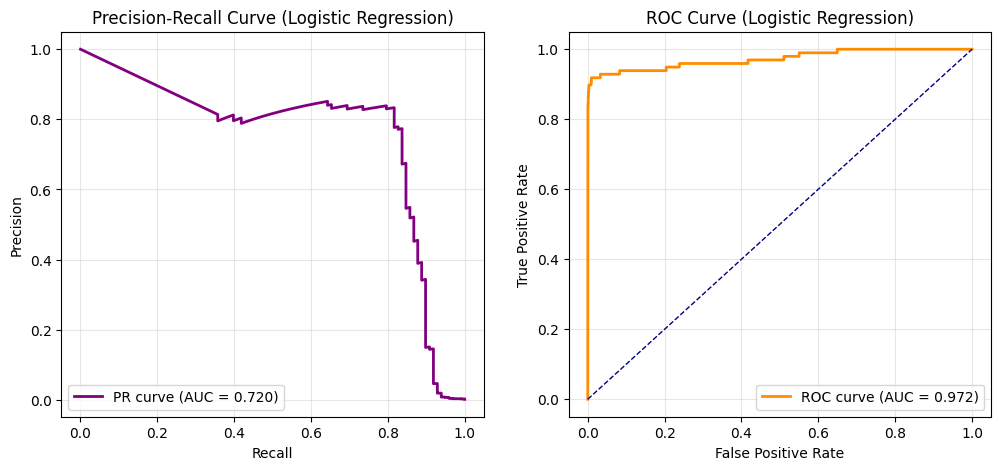

In [41]:
# -- Plot evaluation curves for Logistic Regression
prec, recall, _ = precision_recall_curve(y_test, prob_lr)
fpr, tpr, _ = roc_curve(y_test, prob_lr)

pr_auc = average_precision_score(y_test, prob_lr)
roc_auc = roc_auc_score(y_test, prob_lr)

plt.figure(figsize=(12,5))


# -- PR curve — displayed
plt.subplot(1, 2, 1)
plt.plot(recall, prec, color='purple', lw=2,
         label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Logistic Regression)')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)

# -- ROC curve — displayed
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Logistic Regression)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

In [43]:
# -- Metrics table for KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
prob_knn = evaluate_model(knn, X_train_sel, y_train, X_test_sel, y_test, "KNN")

[KNN] PR-AUC: 0.8360 | ROC-AUC: 0.9335 | F1@0.5: 0.8315
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9997     56864
           1     0.9250    0.7551    0.8315        98

    accuracy                         0.9995     56962
   macro avg     0.9623    0.8775    0.9156     56962
weighted avg     0.9994    0.9995    0.9994     56962



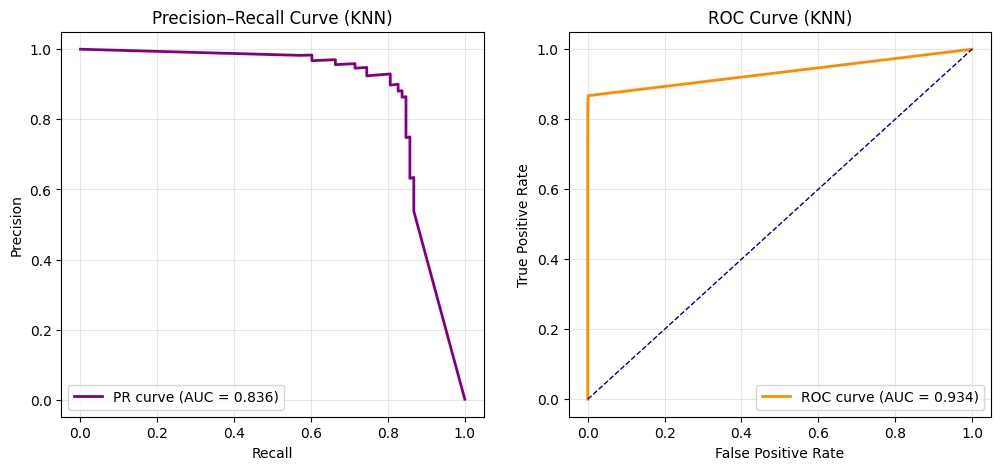

In [45]:
# -- Plot evaluation curves for KNN
prec, recall, _ = precision_recall_curve(y_test, prob_knn)
fpr, tpr, _ = roc_curve(y_test, prob_knn)

pr_auc = average_precision_score(y_test, prob_knn)
roc_auc = roc_auc_score(y_test, prob_knn)

plt.figure(figsize=(12,5))

# -- PR curve — displayed
plt.subplot(1, 2, 1)
plt.plot(recall, prec, color='purple', lw=2,
         label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve (KNN)')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)

# -- ROC curve — displayed
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (KNN)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

In [46]:
# -- Metrics table for Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

prob_rf = evaluate_model(
    rf, X_train_sel, y_train, X_test_sel, y_test, "Random Forest"
)

[Random Forest] PR-AUC: 0.8730 | ROC-AUC: 0.9620 | F1@0.5: 0.8539
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9500    0.7755    0.8539        98

    accuracy                         0.9995     56962
   macro avg     0.9748    0.8877    0.9269     56962
weighted avg     0.9995    0.9995    0.9995     56962



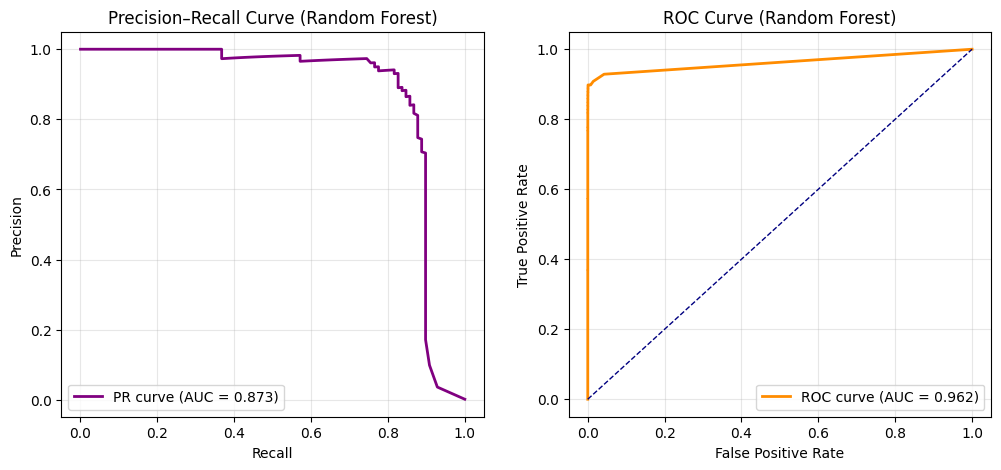

In [47]:
# -- Plot evaluation curves for Random Forest
prec, recall, _ = precision_recall_curve(y_test, prob_rf)
fpr, tpr, _ = roc_curve(y_test, prob_rf)

pr_auc = average_precision_score(y_test, prob_rf)
roc_auc = roc_auc_score(y_test, prob_rf)

plt.figure(figsize=(12,5))

# -- PR curve — displayed
plt.subplot(1, 2, 1)
plt.plot(recall, prec, color='purple', lw=2,
         label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve (Random Forest)')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)

# -- ROC curve — displayed
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

**Note:** Please refer to the detailed explanation for Question 2 & 3 in the report above this section.
A Random Forest Classifier was selected as the third model to compare against Logistic Regression and KNN.  
The model was trained using the top 20 selected features, achieved the most balanced performance.

In [51]:
# -- Avoiding Overfitting and Underfitting using Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_scores = []
for tr_idx, va_idx in skf.split(X_train_sel, y_train):
    X_tr, X_va = X_train_sel[tr_idx], X_train_sel[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]
    
    model = RandomForestClassifier(
        n_estimators=200, class_weight='balanced',
        random_state=RANDOM_STATE, n_jobs=-1
    )
    model.fit(X_tr, y_tr)
    y_va_prob = model.predict_proba(X_va)[:, 1]
    cv_scores.append(average_precision_score(y_va, y_va_prob))

cv_scores = np.array(cv_scores)
print("5-fold PR-AUC:", np.round(cv_scores, 4), "Mean:", np.mean(cv_scores).round(4))

5-fold PR-AUC: [0.8541 0.8131 0.827  0.8674 0.8384] Mean: 0.84


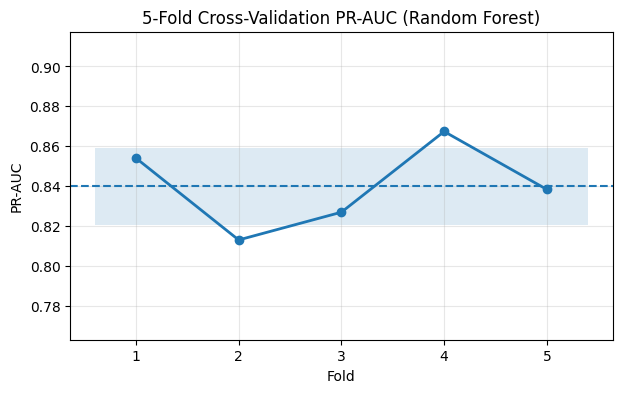

In [52]:
# -- Plot the CV stability
mean_, std_ = cv_scores.mean(), cv_scores.std()

plt.figure(figsize=(7, 4))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', lw=2, label='Fold PR-AUC')
plt.axhline(mean_, ls='--', lw=1.5, label=f"Mean = {mean_:.3f}")
plt.fill_between([0.6, len(cv_scores) + 0.4], mean_ - std_, mean_ + std_, alpha=0.15, label=f"±1σ = {std_:.3f}")

plt.title("5-Fold Cross-Validation PR-AUC (Random Forest)")
plt.xlabel("Fold")
plt.ylabel("PR-AUC")
plt.ylim(max(0, cv_scores.min() - 0.05), min(1, cv_scores.max() + 0.05))
plt.grid(alpha=0.3)

**Note:** Please refer to the detailed explanation for Question 4 in the report above this section.

,feature,importance
11,V12,0.001110
13,V14,0.000959
10,V11,0.000699
2,V3,0.000674
3,V4,0.000555
9,V10,0.000467
8,V9,0.000084
15,V16,0.000046
16,V17,0.000042
25,V26,0.000042


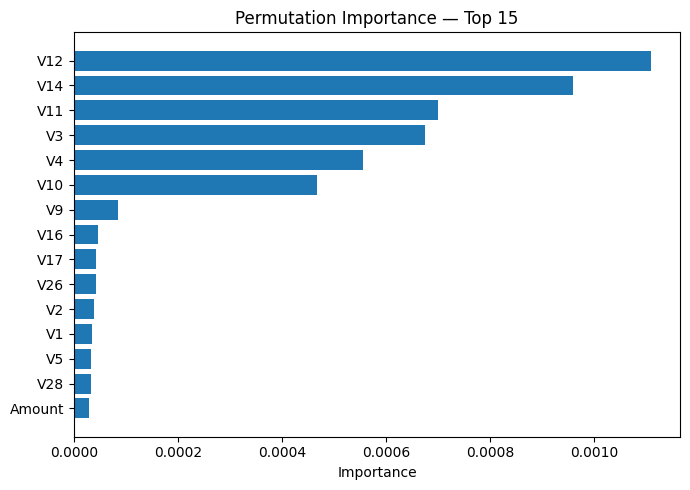

In [ ]:
# -- Evaluate Feature Importance using Permutation Importance
rf_named = make_pipeline(preprocess, RandomForestClassifier(
    n_estimators=300, class_weight='balanced',
    random_state=RANDOM_STATE, n_jobs=-1
))
rf_named.fit(X_train, y_train)

perm = permutation_importance(
    rf_named, X_test, y_test,
    n_repeats=5, random_state=RANDOM_STATE, n_jobs=-1
)

imp_df = pd.DataFrame({
    "feature": X.columns,
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False)

display(imp_df.head(15))

plt.figure(figsize=(7,5))
plt.barh(imp_df.head(15)["feature"][::-1], imp_df.head(15)["importance"][::-1])
plt.title("Permutation Importance — Top 15")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

**Note:** Please refer to the detailed explanation for Question 5 in the report above this section.